In [1]:
from Simulation.helper_functions import mol_to_traj, get_dihedrals_by_name
import mdtraj
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from Simulation.helper_functions import kjmol_to_prop, get_cluster_asignments_ordered, SOLVENT_DICT
from matplotlib import cm
import os


def get_color_from_sd(sd):
    return cm.RdBu(sd/80)

In [2]:
figure_location = "/fileserver/birch/birch1/kpaul/pine8/QMGNN/manuscript/plots"
os.makedirs(figure_location, exist_ok=True)

## Define Functions

In [3]:
from Simulation.helper_functions import calculate_entropy_from_frequencies
def normal_modes(
    hessian_matrix=None, realAtomIdxs=None, masses=None
):
    """
    Adapted from https://leeping.github.io/forcebalance/doc/html/api/openmmio_8py_source.html

    OpenMM Normal Mode Analysis
    Since OpenMM doesnot provide a Hessian evaluation method, we used finite difference on forces

    Parameters
    ----------
    shot: int
        The frame number in the trajectory of this target
    optimize: bool, default True
        Optimize the geometry before evaluating the normal modes

    Returns
    -------
    freqs: np.array with shape (3N - 6) x 1, N = number of "real" atoms
        Harmonic frequencies, sorted from smallest to largest, with the 6 smallest removed, in unit cm^-1
    normal_modes: np.array with shape (3N - 6) x (3N), N = number of "real" atoms
        The normal modes corresponding to each of the frequencies, scaled by mass^-1/2.
    """

    # Mass weight hessian

    mass_weighted_hessian = np.zeros(hessian_matrix.shape)
    for i in range(len(realAtomIdxs) * 3):
        for j in range(len(realAtomIdxs) * 3):
            mass_weighted_hessian[i][j] = hessian_matrix[i][j] / np.sqrt(masses[i//3] * masses[j//3])

    # step 1: build a full hessian matrix
    noa = len(realAtomIdxs)
    # step 2: diagonalize the hessian matrix
    eigvals, eigvecs = np.linalg.eigh(mass_weighted_hessian)
    # step 3: convert eigenvalues to frequencies
    coef = 0.5 / np.pi * 33.3564095  # 10^12 Hz => cm-1
    negatives = (eigvals >= 0).astype(int) * 2 - 1  # record the negative ones
    freqs = np.sqrt(eigvals + 0j) * coef * negatives
    # step 4: convert eigenvectors to normal modes
    # re-arange to row index and shape
    normal_modes = eigvecs.T.reshape(noa * 3, noa, 3)
    # step 5: Remove mass weighting from eigenvectors
    massList = np.array(masses) # unit in dalton
    for i in range(normal_modes.shape[0]):
        mode = normal_modes[i]
        mode /= np.sqrt(massList[:, np.newaxis])
        mode /= np.linalg.norm(mode)
    # step 5: remove the 6 freqs with smallest abs value and corresponding normal modes
    n_remove = 5 if len(realAtomIdxs) == 2 else 6
    larger_freq_idxs = np.sort(np.argpartition(np.abs(freqs), n_remove)[n_remove:])
    # larger_freq_idxs = np.sort(np.argpartition(np.abs(freqs), n_remove))[n_remove:]
    freqs = freqs[larger_freq_idxs]
    normal_modes = normal_modes[larger_freq_idxs]
    return freqs, normal_modes

## Read in Results

In [4]:
file_location = "/fileserver/birch/birch1/kpaul/pine8/QMGNN/MB_results/"

### Setup

In [5]:
set1 = ["N","Nc2ccccc2","Nc2ccccc(C#N)2","Nc2ccccc(OC)2"]
set2 = ["NC(=O)C","NC(=O)C(F)(F)F","NC(=O)C(C)(C)C","NC(=O)c2ccccc2","NC(=O)c2cc(OC)ccc2","NC(=O)c2ccc(F)cn2","NC(=O)c2ccccn2"]
As, Bs, Cs, Ds = [], [], [], []
for X in set1:
    As.append("Fc1ccc(N(C=O)Cc2ccccc2%s)cc1" % X)
    Bs.append("Fc1ccc(N(C=O)CCc2ccccc2%s)cc1" % X)
for X in set2:
    Cs.append("Fc1ccc(N(C=O)Cc2ccccc2%s)cc1" % X)
    Ds.append("Fc1ccc(N(C=O)CCc2ccccc2%s)cc1" % X)

all_compounds = As + Bs + Cs + Ds

In [6]:
mb_dict = {"A1":As[0],"B1":Bs[0],"C1":Cs[0],"D1":Ds[0],"A2":As[1],"B2":Bs[1],"C2":Cs[1],"D2":Ds[1],"A3":As[2],"B3":Bs[2],"C3":Cs[2],"D3":Ds[2],
           "A4":As[3],"B4":Bs[3],"C4":Cs[3],"D4":Ds[3],"C5":Cs[4],"D5":Ds[4],"C6":Cs[5],"D6":Ds[5],
           "C7":Cs[6],"D7":Ds[6]}

### Readin

In [125]:
import pickle
if os.path.exists("all_results_ORCA_MB.pkl"):
    all_results_ORCA = pickle.load(open("all_results_ORCA_MB.pkl", "rb"))
else:
    all_results_ORCA = {}

In [126]:
# all_results_ORCA = {}
solvent_mapping = {
    "chloroform": "Chloroform",
    "methanol": "Methanol",
    "dmso": "DMSO",
    "thf": "THF",
    "acetonitrile": "acetonitrile",
    "acetone": "acetone",
    "ethanol": "Ethanol",
    "ethylacetate": "Ethylacetate",
    "DCM":"DCM"
}
for mb in mb_dict.keys():
    if mb in all_results_ORCA.keys():
        continue

    smiles = mb_dict[mb]
    folder = file_location + "/%s_start_orca_min_hessian_no_mpi_f025" % mb
    nconfs = 1



    gnn_results_ORCA = {}
    cosmors_results_ORCA = {}
    gnn_results_ORCA_ASE = {}
    smd_results_ORCA = {}
    gnn_smd_results_ORCA = {}

    for solvent in solvent_mapping.values():
        SEED_RESULTS = {}
        free_energies = []
        positions = []
        try:
            def probability_to_kjmol_dif(p1,p2):
                return -8.314 * 298 * np.log(p1/p2) / 1000
            thresh = 0.00000000000075
            def get_results(folder,solvent,nconfs,method):
                mol = Chem.MolFromSmiles(smiles)
                permutations = mol.GetSubstructMatches(mol,useChirality=True,uniquify=False)
                mol = Chem.AddHs(mol)
                AllChem.EmbedMolecule(mol)
                traj = mol_to_traj(mol)
                free_energies = []
                positions = []
                num_samples = max([int(f.split("_")[1].split(".")[0]) for f in os.listdir(folder) if solvent in f])
                for seed in range(0,num_samples+1):
                    try:
                        results = SEED_RESULTS.get(seed,None)
                        if results is None:
                            results = np.load(f"{folder}/{solvent}_{seed}.npy",allow_pickle=True)
                            SEED_RESULTS[seed] = results

                        if method == "gnn_orca":
                            free_energies.append(results[0][3])
                            positions.append(results[0][0])
                        elif method == "cosmors_orca":
                            free_energies.append(results[0][2])
                            positions.append(results[0][0])
                        elif method == "smd_orca":
                            free_energies.append(results[0][1])
                            positions.append(results[0][0])
                        elif method == "gnn_orca_ase":
                            hessian = results[0,10]*96.485332 + results[0,11]
                            masses = np.array([atom.GetMass() for atom in mol.GetAtoms()]).round(0)
                            idices = [atom.GetIdx() for atom in mol.GetAtoms()]
                            freqs, nm = normal_modes(hessian, idices, masses)
                            # test if any freqs is complex
                            assert np.sum(np.iscomplex(freqs)) == 0 # Complex Frequency
                            vib_entropy = calculate_entropy_from_frequencies(freqs)
                            free_energy = results[0,12] - vib_entropy
                            positions.append(results[0][8])
                            free_energies.append(free_energy)
                            
                        elif method == "gnn_smd_orca":
                            free_energies.append(results[0][6])
                            positions.append(results[0][0])
                    except:
                        continue
                energies = np.array(free_energies)
                try:
                    traj.xyz = np.array(positions)#[energies != np.inf]
                except Exception as e:
                    print(solvent,method)
                energies = energies#[energies != np.inf]
                dhcalc = get_dihedrals_by_name(traj, *'C4 N1 C5 H3'.split(' '))
                closed_open_flag = ((dhcalc < -2) | (dhcalc > 2))


                if thresh > 0.00001:
                    cluster_traj, cluster_energies = get_cluster_asignments_ordered(traj=traj,energies=energies,
                                                                                    energy_thresh=100,thresh=thresh,
                                                                                    additional_requirements=closed_open_flag,
                                                                                    permutations=permutations)
                else:                    
                    cluster_traj = mdtraj.Trajectory(traj.xyz[energies.argsort()], traj.top)
                    cluster_energies = energies[energies.argsort()]

                dhcalc = get_dihedrals_by_name(cluster_traj, *'C4 N1 C5 H3'.split(' ')).flatten()
                closed_states = []
                open_states = []

                for i in range(cluster_traj.n_frames):

                    if (dhcalc[i] < -2) or (dhcalc[i] > 2):
                        closed_states.append(cluster_energies[i])
                    else:
                        open_states.append(cluster_energies[i])

                props = kjmol_to_prop(np.array(open_states+closed_states)-np.min(cluster_energies))
                props1 = np.sum(props[:len(open_states)])
                props2 = np.sum(props[len(open_states):])
                kjmol_diff = probability_to_kjmol_dif(props1,props2)
                print((np.array(energies) == np.inf).sum())
                print(solvent,(np.array(cluster_energies) != np.inf).sum(),len(cluster_energies),len(cluster_traj))

                return (kjmol_diff, cluster_energies, cluster_traj,free_energies,closed_open_flag)
            
            gnn_results_ORCA_ASE[solvent] = get_results(folder,solvent,nconfs,"gnn_orca_ase")
            gnn_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"gnn_orca")
            smd_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"smd_orca")
            gnn_smd_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"gnn_smd_orca")
            cosmors_results_ORCA[solvent] = get_results(folder,solvent,nconfs,"cosmors_orca")
        except Exception as e:
            print(e)
            continue
    all_results_ORCA[mb] = (gnn_results_ORCA,cosmors_results_ORCA,gnn_results_ORCA_ASE,smd_results_ORCA,gnn_smd_results_ORCA)


In [127]:
import pickle
pickle.dump(all_results_ORCA,open("all_results_ORCA_MB.pkl","wb"))

## Plot Results

In [11]:
exp_folder = "../experimental_data/"

In [128]:
import pandas as pd
from scipy.stats import pearsonr

pinfs = []
for all_results in [all_results_ORCA]:
    all_plotting_info = {}
    for mb in all_results.keys():
        gnn_results_ORCA,cosmors_results_ORCA,gnn_results_ORCA_ASE,smd_results_ORCA,gnn_smd_results_ORCA = all_results[mb]
        df = pd.read_csv(f"{exp_folder}/MB_experimental_references.csv",index_col=0)
        solvents = ['Chloroform','acetone','acetonitrile','Ethylacetate','THF','DCM','Ethanol','Methanol','DMSO']
        mapping_s = {"chloroform":"Chloroform","acetone":"acetone","acetonitrile":"acetonitrile","ethylacetate":"Ethylacetate","thf":"THF","benzene":"Benzol","ethanol":"Ethanol","methanol":"Methanol","dmso":"DMSO"}
        exp=[]
        exp_std = []
        for i in solvents:
            if "nan" not in df[mb][i]:
                exp.append(eval(df[mb][i])[0])
                exp_std.append([eval(df[mb][i])[1],eval(df[mb][i])[2]])
            else:
                exp.append(np.nan)
                exp_std.append([np.nan,np.nan])

        gnn_orca_dif = np.array([gnn_results_ORCA[solvent][0] if solvent in gnn_results_ORCA.keys() else np.nan for solvent in solvents ])
        cosmors_orca_dif = np.array([cosmors_results_ORCA[solvent][0] if solvent in cosmors_results_ORCA.keys() else np.nan  for solvent in solvents])
        gnn_orca_ace_dif = np.array([gnn_results_ORCA_ASE[solvent][0] if solvent in gnn_results_ORCA_ASE.keys() else np.nan  for solvent in solvents])
        smd_orca_dif = np.array([smd_results_ORCA[solvent][0] if solvent in smd_results_ORCA.keys() else np.nan  for solvent in solvents])
        gnn_smd_orca_dif = np.array([gnn_smd_results_ORCA[solvent][0] if solvent in gnn_smd_results_ORCA.keys() else np.nan  for solvent in solvents])
        exp_dif = np.array(exp)
        color = [get_color_from_sd(SOLVENT_DICT[solvent]["dielectric"]) for solvent in solvents]
        names = [solvent for solvent in solvents]

        all_plotting_info[mb] = (gnn_orca_dif,cosmors_orca_dif,gnn_orca_ace_dif,smd_orca_dif,gnn_smd_orca_dif,exp_dif,color,names,exp_std)
    pinfs.append(all_plotting_info)

In [129]:
all_results["A1"][0].keys()


dict_keys(['Chloroform', 'Methanol', 'DMSO', 'THF', 'acetonitrile', 'acetone', 'Ethanol', 'Ethylacetate', 'DCM'])

### Single Plots all methods

/tmp/ipykernel_1699051/592085822.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axd = plt.subplot_mosaic([["smd_orca","cosmors_orca","gnn_orca_ase"]],figsize=(7,2.5),constrained_layout=True,empty_sentinel="EMPTY")


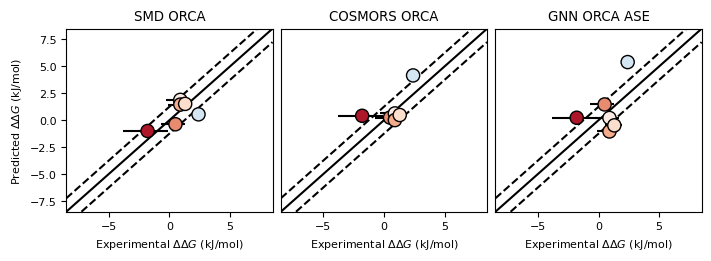

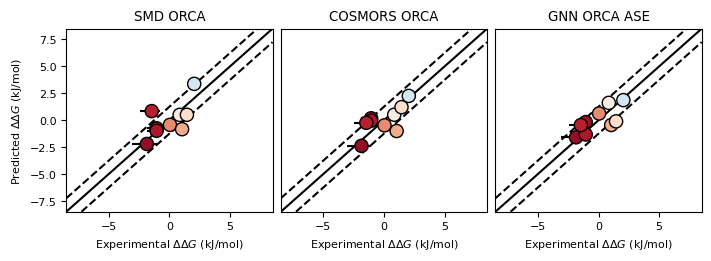

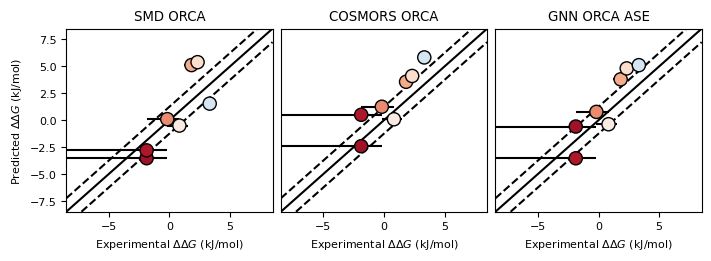

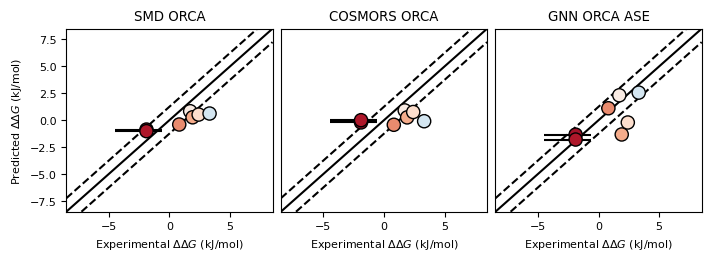

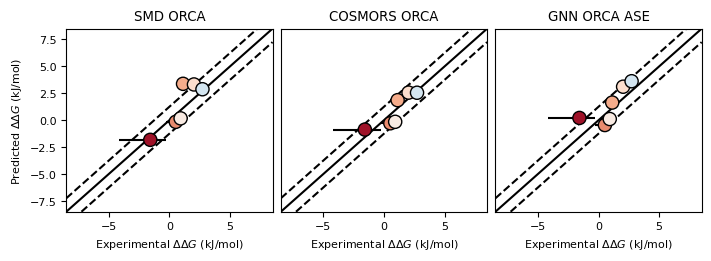

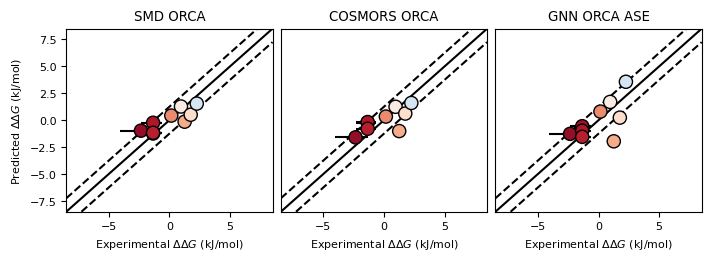

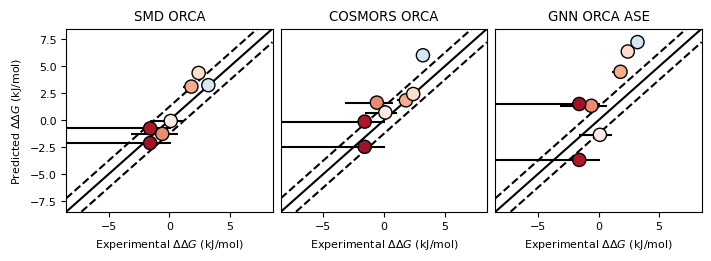

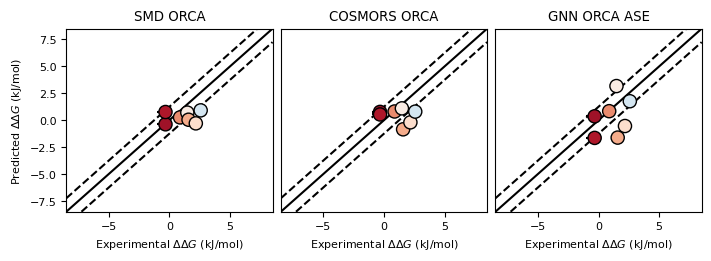

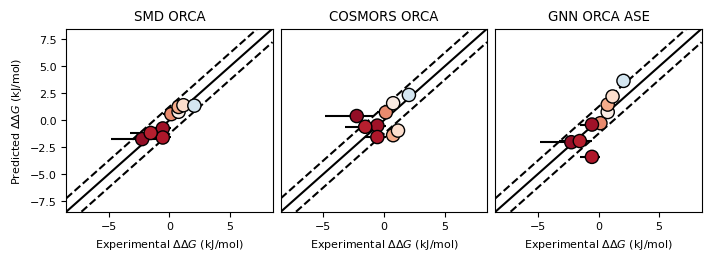

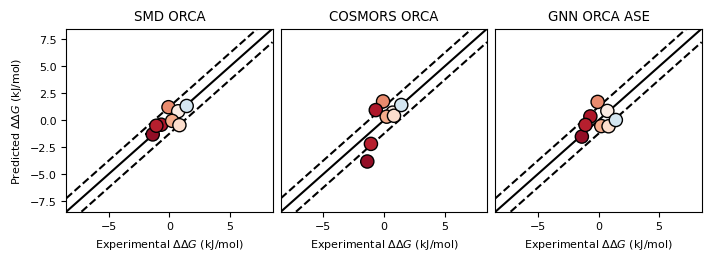

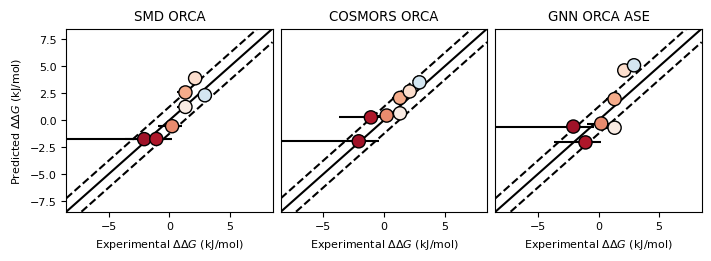

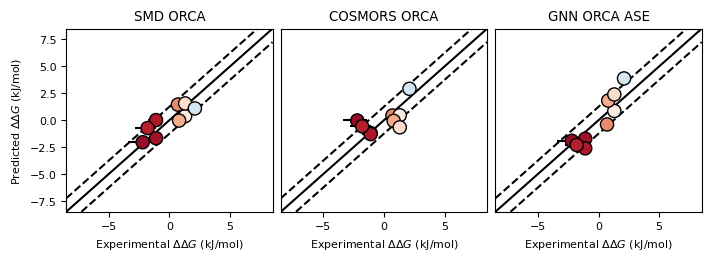

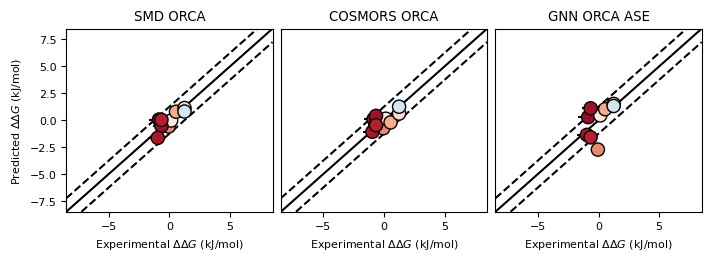

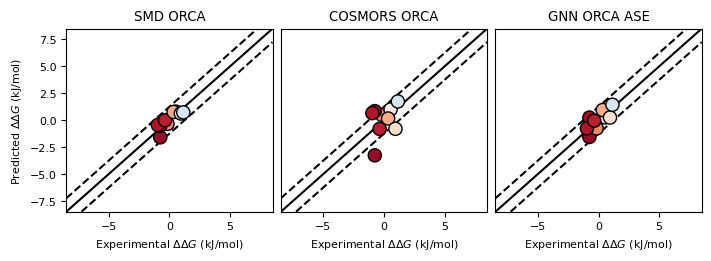

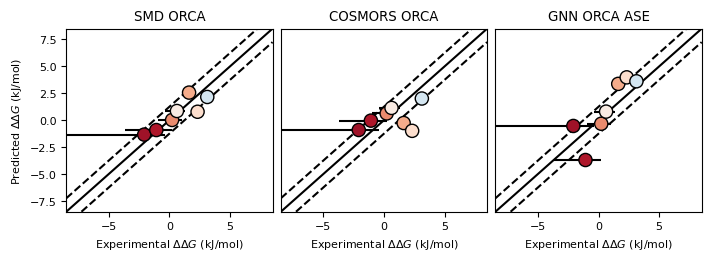

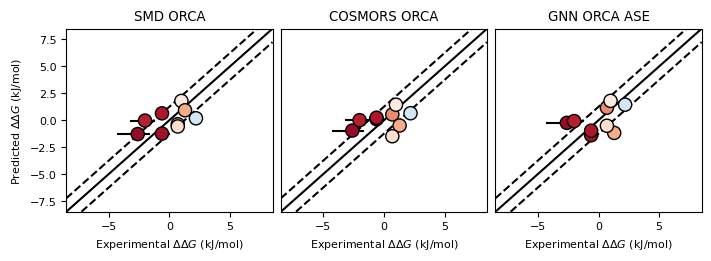

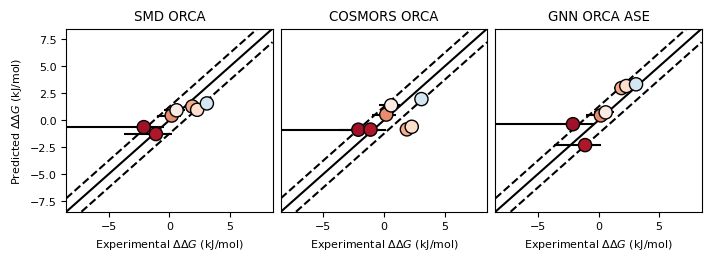

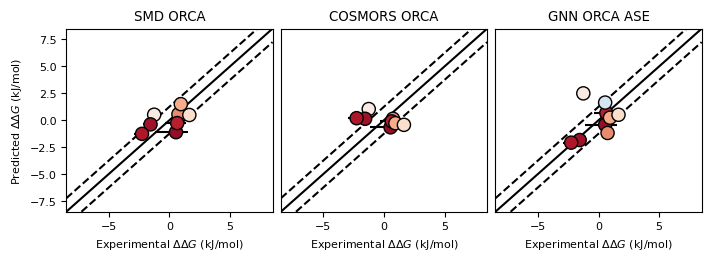

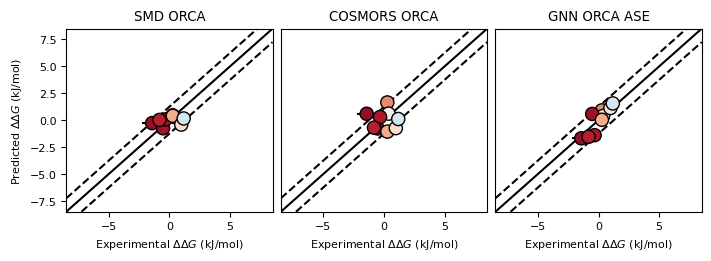

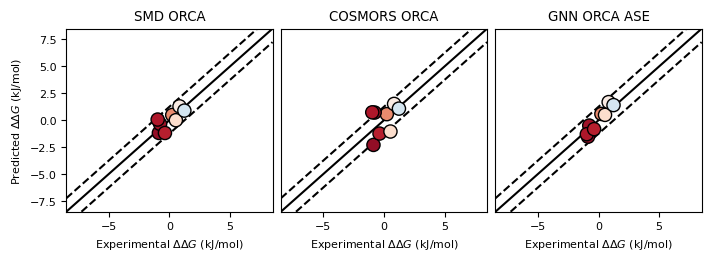

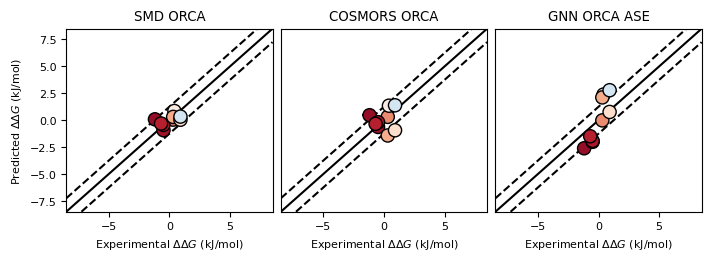

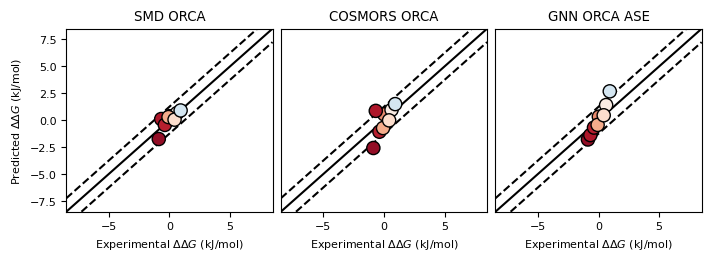

In [130]:
# set font size
plt.rcParams.update({'font.size': 8})

for mb in all_plotting_info.keys():
    fig, axd = plt.subplot_mosaic([["smd_orca","cosmors_orca","gnn_orca_ase"]],figsize=(7,2.5),constrained_layout=True,empty_sentinel="EMPTY")

    def plot_comp(ax,exp_dif,predicted_dif,exp_std,exclude_unknonws=False):
        exp_dif = np.array(exp_dif)
        predicted_dif = np.array(predicted_dif)
        exp_std = np.array(exp_std)
        colors = np.array(color)
        if exclude_unknonws:
            exp_dif = exp_dif[(exp_std[:,0] != 2) | (exp_std[:,1]!=0)]
            predicted_dif = predicted_dif[(exp_std[:,0] != 2) | (exp_std[:,1]!=0)]
            colors = colors[(exp_std[:,0] != 2) | (exp_std[:,1]!=0)]
            exp_std = exp_std[(exp_std[:,0] != 2) | (exp_std[:,1]!=0)]
        
        ex_ = np.array(exp_dif)
        pr_ = np.array(predicted_dif)
        pr_ = pr_[(ex_ == ex_)]
        ex_ = ex_[(ex_ == ex_)]

        # ax.text(0,0.9,f"PCC: {pearsonr(ex_,pr_)[0]:.2f}",transform=ax.transAxes)

        ax.scatter(exp_dif,predicted_dif,c=colors,s=90,marker='o',edgecolors='black')
        ax.errorbar(exp_dif,predicted_dif,xerr=exp_std.T,fmt='o',color='black',zorder=0)
        ax.set_xlabel("Predicted Population of trans rotamer")
        ax.set_ylabel("JHH + JHH' Coupling (Hz)")
        # ax.set_title("GNN")

        for i in range(len(predicted_dif)):

            shifty=0.1
            shiftx=0.25
            #ax.text(predicted_dif[i]+0.002+shiftx,exp_dif[i]+shifty,SOLVENT_DICT[names[i]]["nice_name"],fontsize=8)

    modify = lambda x: x - np.nanmean(x)

    try:
        gnn_orca_dif,cosmors_orca_dif,gnn_orca_ace_dif,smd_orca_dif,gnn_smd_orca_dif,exp_dif,color,names,exp_std = pinfs[0][mb]

        plot_comp(axd["cosmors_orca"],modify(exp_dif),modify(cosmors_orca_dif),exp_std,exclude_unknonws=True)
        plot_comp(axd["smd_orca"],modify(exp_dif),modify(smd_orca_dif),exp_std,exclude_unknonws=True)
        plot_comp(axd["gnn_orca_ase"],modify(exp_dif),modify(gnn_orca_ace_dif),exp_std,exclude_unknonws=True)

        axd["cosmors_orca"].set_title("COSMORS ORCA")
        axd["smd_orca"].set_title("SMD ORCA")
        axd["gnn_orca_ase"].set_title("GNN ORCA ASE")

        lims = 8.5
        # lims = 20

        kbt = 2.5 / 2
        for ax in axd.values():
            ax.set_ylabel("Predicted $\Delta\Delta G$ (kJ/mol)")
            ax.set_xlabel("Experimental $\Delta\Delta G$ (kJ/mol)")
            ax.set_xlim(-lims,lims)
            ax.set_ylim(-lims,lims)
            ax.axline((0,0),(1,1),color='black',zorder=0,linestyle='-')
            ax.axline((0,1*kbt),(1,1+kbt),color='black',zorder=0,linestyle='--')
            ax.axline((0,-kbt),(1,1-kbt),color='black',zorder=0,linestyle='--')
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
        
        axd["smd_orca"].get_yaxis().set_visible(True)
        axd["smd_orca"].get_xaxis().set_visible(True)
        axd["cosmors_orca"].get_xaxis().set_visible(True)
        axd["gnn_orca_ase"].get_xaxis().set_visible(True)
    except Exception as e:
        print(e)
        continue

    plt.savefig(f"Draft_Figures/{mb}_single_MB.pdf",bbox_inches='tight')

### One Method all Plots

In [131]:
from matplotlib.patches import Patch
from scipy.stats import pearsonr, linregress, spearmanr
import scipy

In [132]:
scipy.__version__

'1.10.1'

In [133]:
def plot_comp(ax,exp_dif,predicted_dif,exp_std,exclude_unknonws=False,symbols=["^","^","o","s","o","v","v","s","o"],s_size=30):
    exp_dif = np.array(exp_dif)
    predicted_dif = np.array(predicted_dif)
    exp_std = np.array(exp_std)
    colors = np.array(color)
    symbols = np.array(symbols)

    if exclude_unknonws:
        exp_dif = exp_dif[(exp_std[:,0] != 2) | (exp_std[:,1]!=0)]
        predicted_dif = predicted_dif[(exp_std[:,0] != 2) | (exp_std[:,1]!=0)]
        colors = colors[(exp_std[:,0] != 2) | (exp_std[:,1]!=0)]
        symbols = symbols[(exp_std[:,0] != 2) | (exp_std[:,1]!=0)]
        exp_std = exp_std[(exp_std[:,0] != 2) | (exp_std[:,1]!=0)]

    exp_dif = modify(exp_dif)
    predicted_dif = modify(predicted_dif)
    
    ex_ = np.array(exp_dif,dtype=float)
    pr_ = np.array(predicted_dif,dtype=float)
    pr_ = pr_[(ex_ == ex_)]
    ex_ = ex_[(ex_ == ex_)]

    pr_ = pr_[(ex_ != np.inf) | (ex_ != -np.inf)]
    ex_ = ex_[(ex_ != np.inf) | (ex_ != -np.inf)]

    ex_ = ex_[(pr_ != np.inf) | (pr_ != -np.inf)]
    pr_ = pr_[(pr_ != np.inf) | (pr_ != -np.inf)]

    ex_ = ex_[(pr_ == pr_)]
    pr_ = pr_[(pr_ == pr_)]

    # ax.text(0,0.9,f"PCC: {pearsonr(ex_,pr_)[0]:.2f}",transform=ax.transAxes)

    for e,p,c,s,estd in zip(exp_dif,predicted_dif,colors,symbols,exp_std):
        if (estd[0] == 0) or (estd[1] == 0):
            lwp = 1.00
            ec = c
            c = "lightgrey"
        else:
            ec = "black"
            lwp = 0.25
        ax.scatter(e,p,c=c,s=s_size,edgecolor=ec,linewidth=lwp,marker=s)

    # ax.scatter(exp_dif,predicted_dif,c=colors,s=45,marker='o',edgecolors='black')
    ax.errorbar(exp_dif,predicted_dif,xerr=exp_std.T,zorder=0,linewidth=0.25,fmt=".",markersize=1,color='grey')
    ax.set_xlabel("Predicted Population of trans rotamer")
    ax.set_ylabel("JHH + JHH' Coupling (Hz)")
    # ax.set_title("GNN")

    for i in range(len(predicted_dif)):

        shifty=0.1
        shiftx=0.25
        #ax.text(predicted_dif[i]+0.002+shiftx,exp_dif[i]+shifty,SOLVENT_DICT[names[i]]["nice_name"],fontsize=8)
    
    pearsons = pearsonr(ex_,pr_).statistic
    slope = linregress(ex_,pr_).slope
    if slope > 0:
        slopes = np.log10(slope)
    else:
        slopes = -np.inf
    spearman = spearmanr(ex_,pr_).correlation

    return pearsons,slopes,spearman

In [134]:
gnn_orca_dif,cosmors_orca_dif,gnn_orca_ace_dif,smd_orca_dif,gnn_smd_orca_dif,exp_dif,color,names,exp_std = pinfs[0]["A1"]

/tmp/ipykernel_1699051/2608778072.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(e,p,c=c,s=s_size,edgecolor=ec,linewidth=lwp,marker=s)


SMD:  A1 (0.6318313732153478, -0.2775273689005974, 0.550782483869826)
SMD:  B1 (0.6673661781865786, -0.1266069086251804, 0.5355695416036628)
SMD:  C1 (0.8187575247202098, 0.15093355182797288, 0.8468812149338255)
SMD:  D1 (0.9222111165481786, -0.4729723673893199, 0.7748062179181807)
SMD:  A2 (0.8570409067599308, 0.10470303463344983, 0.7714285714285715)
SMD:  B2 (0.8423531986727748, -0.2810168136962481, 0.8306277919354929)
SMD:  C2 (0.9412802146351116, 0.09683541365595505, 0.900937462695559)
SMD:  D2 (0.17435574860059058, -1.0975594532389603, 0.23424374030084538)
SMD:  A3 (0.9132697203971414, -0.05310552573421871, 0.9496133617021003)
SMD:  B3 (0.7135820460857029, -0.16464338153701455, 0.6904761904761906)
SMD:  C3 (0.9007421831496893, 0.05603437310832528, 0.8648999641877367)
SMD:  D3 (0.8341572460008573, -0.15935046020432436, 0.7731365422707366)
SMD:  A4 (0.7988826629917647, -0.09814346459839438, 0.7311182519299356)
SMD:  B4 (0.8331393066028554, -0.06102730727993808, 0.7949860383179369)
S

/tmp/ipykernel_1699051/2608778072.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(e,p,c=c,s=s_size,edgecolor=ec,linewidth=lwp,marker=s)
/tmp/ipykernel_1699051/2608778072.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(e,p,c=c,s=s_size,edgecolor=ec,linewidth=lwp,marker=s)


GNN:  A1 (0.48631326160169613, -0.08787929245469511, 0.02898855178262242)
GNN:  B1 (0.7334846871505221, -0.21050886125631602, 0.7782494901428225)
GNN:  C1 (0.9145933431220887, 0.1637041507948946, 0.9549937104572924)
GNN:  D1 (0.6722329922975082, -0.22690547533648167, 0.702731220902536)
GNN:  A2 (0.7700070567917681, -0.05295450959458601, 0.8285714285714287)
GNN:  B2 (0.6342976370463738, -0.1624295707554088, 0.5085476277156078)
GNN:  C2 (0.8679413002838501, 0.2526476146391379, 0.8108437164260032)
GNN:  D2 (0.32776668455366464, -0.29308110879039495, 0.30631873731649006)
GNN:  A3 (0.8716224738847806, 0.1604763946292785, 0.9244023874976197)
GNN:  B3 (0.33062032963656346, -0.47819044734907806, 0.19047619047619052)
GNN:  C3 (0.8152615483952232, 0.11089739106103051, 0.7748062179181807)
GNN:  D3 (0.9151716613757639, 0.137807026762388, 0.8823840971568188)
GNN:  A4 (0.5430320922465952, -0.018991902358257165, 0.655485329316494)
GNN:  B4 (0.7366575455738005, -0.06033212819375989, 0.7531446678801508

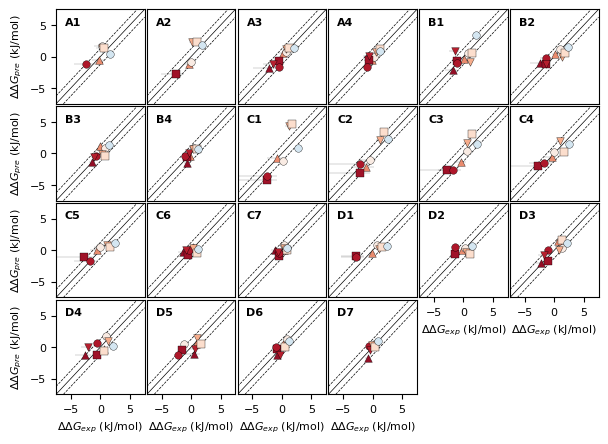

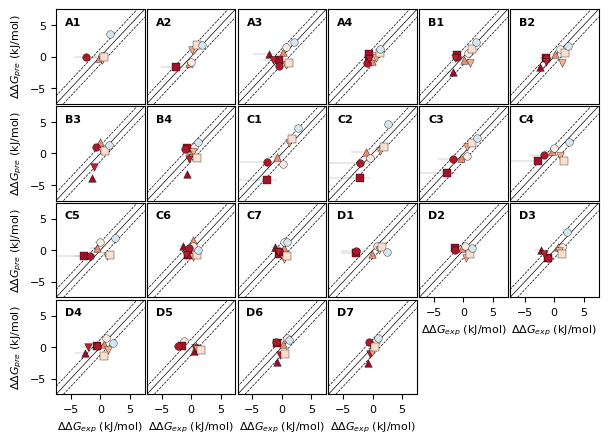

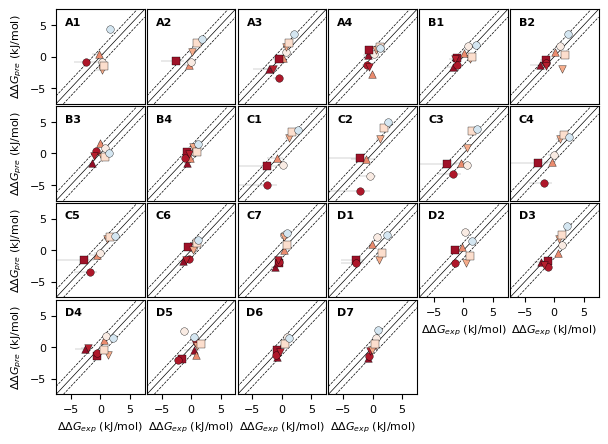

In [138]:
cmt = 1/2.54

all_res = []

solvents = solvent_mapping.values()
labels = ["A%i" % (i+1) for i in range(4)] + ["B%i" % (i+1) for i in range(4)] + ["C%i" % (i+1) for i in range(7)] + ["D%i" % (i+1) for i in range(7)]

gnn_metrics = []
cosmors_metrics = []
smd_metrics = []

for ad,results in zip(["SMD","COSMORS","GNN"],["smd_orca","cosmors_orca","gnn_orca_ase"]):

    fig, axd = plt.subplot_mosaic([[labels[j+i*6] if (j+i*6 < 22) else "legend" for j in range(6)] for i in range(4)],
                              figsize=(7,5),empty_sentinel="EMPTY",
                            )

    all_exp = []
    all_pre = []

    for mb in all_plotting_info.keys():
        
        gnn_orca_dif,cosmors_orca_dif,gnn_orca_ace_dif,smd_orca_dif,gnn_smd_orca_dif,exp_dif,color,names,exp_std = pinfs[0][mb]

        try:
            if results == "smd_orca":
                smd_metrics.append(plot_comp(axd[mb],modify(exp_dif),modify(smd_orca_dif),exp_std,exclude_unknonws=True))
                print("SMD: ",mb,smd_metrics[-1])
            elif results == "cosmors_orca":
                cosmors_metrics.append(plot_comp(axd[mb],modify(exp_dif),modify(cosmors_orca_dif),exp_std,exclude_unknonws=True))
            elif results == "gnn_orca_ase":
                gnn_metrics.append(plot_comp(axd[mb],modify(exp_dif),modify(gnn_orca_ace_dif),exp_std,exclude_unknonws=True))
                print("GNN: ",mb,gnn_metrics[-1])
        except Exception as e:
            print(e)
            continue

        axd[mb].text(-6,5,mb,fontsize=8,weight="bold")



    lims = 7.5
    # lims = 20

    kbt = 2.5 / 2
    for key in axd.keys():
        if key == "legend":
            continue
        ax = axd[key]
        ax.set_ylabel("$\Delta\Delta G_{pre}$ (kJ/mol)")
        ax.set_xlabel("$\Delta\Delta G_{exp}$ (kJ/mol)")
        ax.set_xlim(-lims,lims)
        ax.set_ylim(-lims,lims)
        ax.axline((0,0),(1,1),color='black',zorder=0,linestyle='-',linewidth=0.5)
        ax.axline((0,1*kbt),(1,1+kbt),color='black',zorder=0,linestyle='--',linewidth=0.5)
        ax.axline((0,-kbt),(1,1-kbt),color='black',zorder=0,linestyle='--',linewidth=0.5)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

    ax = axd["legend"]
    # add legend for colors
    legend_solvents = ['Chloroform','Ethylacetate','THF','DCM','acetone','Ethanol',"Methanol",'acetonitrile','DMSO']
    #ax.legend(handles=[Patch(facecolor=get_color_from_sd(SOLVENT_DICT[solvent]['dielectric']),label=SOLVENT_DICT[solvent]['nice_name']) for solvent in legend_solvents],loc="lower center",ncol=2,fontsize=8)
    ax.axis("off")

    for key in ['D%i' % (i+2) for i in range(6)]:
        axd[key].get_xaxis().set_visible(True)

    for key in ['A1','B3','C5','D4']:
        axd[key].get_yaxis().set_visible(True)

    fig.subplots_adjust(wspace=0.025, hspace=0.025)
    fig.savefig(f"{figure_location}/{ad}_MB.pdf",bbox_inches='tight')

In [78]:
10**-0.4729723673893199

0.33653298108897317

In [79]:
len(gnn_metrics),len(cosmors_metrics),len(smd_metrics)

(22, 22, 22)

In [80]:
np.median(np.array(cosmors_metrics)[:,0]),np.median(np.array(gnn_metrics)[:,0]),np.median(np.array(smd_metrics)[:,0])

(0.5309415801082928, 0.7926343025934957, 0.8088200938559873)

In [81]:
np.median(np.array(cosmors_metrics)[:,2]),np.median(np.array(gnn_metrics)[:,2]),np.median(np.array(smd_metrics)[:,2])

(0.49720718781324696, 0.7945466032844128, 0.7722825568496541)

## Make A1 - D1

In [82]:
plt.rcParams.update({'font.size': 8})

/tmp/ipykernel_1699051/2608778072.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(e,p,c=c,s=s_size,edgecolor=ec,linewidth=lwp,marker=s)
/tmp/ipykernel_1699051/2608778072.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(e,p,c=c,s=s_size,edgecolor=ec,linewidth=lwp,marker=s)
/tmp/ipykernel_1699051/2608778072.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which s

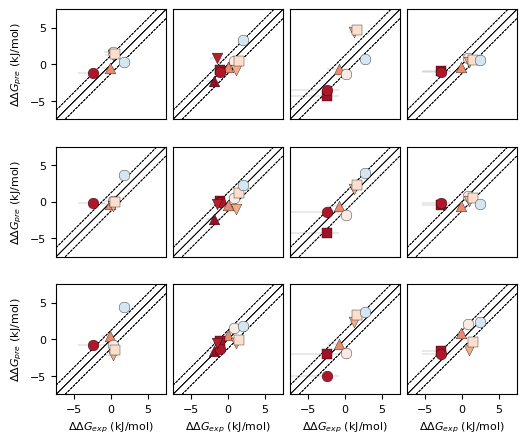

In [83]:
cmt = 1/2.54

all_res = []

solvents = solvent_mapping.values()
labels = ["A%i" % (i+1) for i in range(4)] + ["B%i" % (i+1) for i in range(4)] + ["C%i" % (i+1) for i in range(7)] + ["D%i" % (i+1) for i in range(7)]

fig, axd = plt.subplot_mosaic([["A1_SMD","B1_SMD","C1_SMD","D1_SMD"],
                               ["A1_COSMORS","B1_COSMORS","C1_COSMORS","D1_COSMORS"],
                               ["A1_GNN","B1_GNN","C1_GNN","D1_GNN"]],
                            figsize=(6,5),empty_sentinel="EMPTY",
                        )

for ad,results in zip(["SMD","COSMORS","GNN"],["smd_orca","cosmors_orca","gnn_orca_ase"]):

    all_exp = []
    all_pre = []

    for mb in all_plotting_info.keys():
        if mb+"_"+ad not in axd.keys():
            continue
        
        gnn_orca_dif,cosmors_orca_dif,gnn_orca_ace_dif,smd_orca_dif,gnn_smd_orca_dif,exp_dif,color,names,exp_std = pinfs[0][mb]
        s_size = 60
        if results == "smd_orca":
            plot_comp(axd[mb+"_"+ad],modify(exp_dif),modify(smd_orca_dif),exp_std,exclude_unknonws=True,s_size=s_size)
        elif results == "cosmors_orca":
            plot_comp(axd[mb+"_"+ad],modify(exp_dif),modify(cosmors_orca_dif),exp_std,exclude_unknonws=True,s_size=s_size)
        elif results == "gnn_orca_ase":
            plot_comp(axd[mb+"_"+ad],modify(exp_dif),modify(gnn_orca_ace_dif),exp_std,exclude_unknonws=True,s_size=s_size)

        #axd[mb+"_"+ad].text(-6,5,mb,fontsize=8,weight="bold")



    lims = 7.5
    # lims = 20

    kbt = 2.479 / 2
    for key in axd.keys():
        if key == "legend":
            continue
        ax = axd[key]
        ax.set_ylabel("$\Delta\Delta G_{pre}$ (kJ/mol)")
        ax.set_xlabel("$\Delta\Delta G_{exp}$ (kJ/mol)")
        ax.set_xlim(-lims,lims)
        ax.set_ylim(-lims,lims)
        ax.axline((0,0),(1,1),color='black',zorder=0,linestyle='-',linewidth=0.5)
        ax.axline((0,1*kbt),(1,1+kbt),color='black',zorder=0,linestyle='--',linewidth=0.5)
        ax.axline((0,-kbt),(1,1-kbt),color='black',zorder=0,linestyle='--',linewidth=0.5)
        # ax.axline((0,1*kbt*2),(1,1+kbt*2),color='black',zorder=0,linestyle='dotted',linewidth=0.5)
        # ax.axline((0,-kbt*2),(1,1-kbt*2),color='black',zorder=0,linestyle='dotted',linewidth=0.5)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        # set equal
        ax.set_aspect('equal', 'box')

    # ax = axd["legend"]
    # # add legend for colors
    # legend_solvents = ['Chloroform','Ethylacetate','THF','DCM','acetone','Ethanol',"Methanol",'acetonitrile','DMSO']
    # #ax.legend(handles=[Patch(facecolor=get_color_from_sd(SOLVENT_DICT[solvent]['dielectric']),label=SOLVENT_DICT[solvent]['nice_name']) for solvent in legend_solvents],loc="lower center",ncol=2,fontsize=8)
    # ax.axis("off")

    for key in ["A1_GNN","B1_GNN","C1_GNN","D1_GNN"]:
        axd[key].get_xaxis().set_visible(True)

    for key in ['A1_GNN','A1_SMD','A1_COSMORS']:
        axd[key].get_yaxis().set_visible(True)

    fig.subplots_adjust(wspace=0.025, hspace=0.25)
    fig.savefig(f"{figure_location}/First_Three_MB.pdf",bbox_inches='tight')

## Create Boxplots

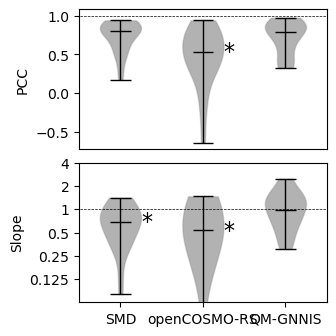

In [118]:
plt.rcParams.update({'font.size': 10})

# fig,axd = plt.subplot_mosaic([["Pearson","Slope"]],figsize=(3.25,2.5),constrained_layout=True,empty_sentinel="EMPTY")

fig,axd = plt.subplot_mosaic([["Pearson"],["Slope"]],figsize=(3.25,3.25),constrained_layout=True,empty_sentinel="EMPTY")
axd["Pearson"].get_xaxis().set_visible(False)

slopes = np.array([np.array(smd_metrics)[:,1],np.array(cosmors_metrics)[:,1],np.array(gnn_metrics)[:,1]])
slopes[slopes == -np.inf] = -2

ax = axd["Slope"]

violine_plot = plt.violinplot(np.array(slopes,dtype=float).T,showmedians=True,positions=[0,1,2])
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violine_plot[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)

for vp in violine_plot['bodies']:
    vp.set_facecolor("black")
    vp.set_edgecolor("grey")
    vp.set_linewidth(1)


ax.hlines(0,-2,10,linestyle="--",linewidth=0.5,colors="black",zorder=0)
log_labels = [0.125,0.25,0.5,1,2,4,8]
ax.set_xticks([0,1,2],["SMD","openCOSMO-RS","QM-GNNIS"],rotation=0)
ax.text(0.25,np.median(slopes[0]),f"*",ha="left",va="center", fontsize=16)
ax.text(1.25,np.median(slopes[1]),f"*",ha="left",va="center", fontsize=16)
ax.set_yticks(np.log10(log_labels),log_labels)
ax.set_xlim(-0.5,2.5)
ax.set_ylim(np.log10(0.0625),np.log10(4))
ax.set_ylabel("Slope")

ax = axd["Pearson"]
pearsons = np.array([np.array(smd_metrics)[:,0],np.array(cosmors_metrics)[:,0],np.array(gnn_metrics)[:,0]])

violine_plot = ax.violinplot(np.array(pearsons,dtype=float).T,showmedians=True,positions=[0,1,2])

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violine_plot[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)

for vp in violine_plot['bodies']:
    vp.set_facecolor("black")
    vp.set_edgecolor("grey")
    vp.set_linewidth(1)
# ax.hlines(0,-2,10,linestyle="--",linewidth=0.5,colors="black",zorder=0)
ax.set_xticks([0,1,2],["SMD","openCOSMO-RS","GNN"],rotation=45)
ax.text(1.25,np.median(pearsons[1]),f"*",ha="left",va="center", fontsize=16)
# ax.text(2.25,np.median(pearsons[2]),f"*",ha="left",va="center", fontsize=16)
# ax.yticks(np.log10(log_labels),log_labels)
ax.set_xlim(-0.5,2.5)
# ax.set_ylim(np.log10(0.0625),np.log10(4))
ax.set_ylabel("PCC")

ax.hlines(1,-2,10,linestyle="--",linewidth=0.5,colors="black",zorder=0)


fig.savefig(f"{figure_location}/slopes_violin.pdf",bbox_inches='tight')

In [29]:
np.array(smd_metrics)[:,0]

array([0.63183137, 0.66736618, 0.81875752, 0.92221112, 0.85704091,
       0.8423532 , 0.94128021, 0.17435575, 0.91326972, 0.71358205,
       0.90074218, 0.83415725, 0.79888266, 0.83313931, 0.87952583,
       0.50822121, 0.90004423, 0.50618246, 0.3220785 , 0.74859691,
       0.52448773, 0.79129953])

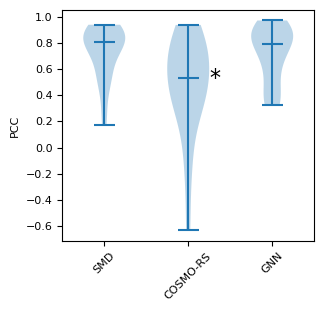

In [85]:
fig = plt.figure(figsize=(3.25,3))
plt.rcParams.update({'font.size': 8})

pearsons = np.array([np.array(smd_metrics)[:,0],np.array(cosmors_metrics)[:,0],np.array(gnn_metrics)[:,0]])

plt.violinplot(np.array(pearsons,dtype=float).T,showmedians=True,positions=[0,1,2])
# plt.hlines(0,-2,10,linestyle="--",linewidth=0.5,colors="black",zorder=0)
plt.xticks([0,1,2],["SMD","COSMO-RS","GNN"],rotation=45)
plt.text(1.25,np.median(pearsons[1]),f"*",ha="left",va="center", fontsize=16)
# plt.text(2.25,np.median(pearsons[2]),f"*",ha="left",va="center", fontsize=16)
# plt.yticks(np.log10(log_labels),log_labels)
plt.xlim(-0.5,2.5)
# plt.ylim(np.log10(0.0625),np.log10(4))
plt.ylabel("PCC")
plt.savefig(f"{figure_location}/pearsons_violin.pdf",bbox_inches='tight')

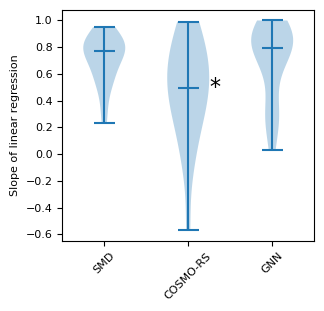

In [86]:
fig = plt.figure(figsize=(3.25,3))
plt.rcParams.update({'font.size': 8})

spearmans = np.array([np.array(smd_metrics)[:,2],np.array(cosmors_metrics)[:,2],np.array(gnn_metrics)[:,2]])

plt.violinplot(np.array(spearmans,dtype=float).T,showmedians=True,positions=[0,1,2],showextrema=True)
# plt.hlines(0,-2,10,linestyle="--",linewidth=0.5,colors="black",zorder=0)
plt.xticks([0,1,2],["SMD","COSMO-RS","GNN"],rotation=45)
plt.text(1.25,np.median(spearmans[1]),f"*",ha="left",va="center", fontsize=16)
# plt.text(2.25,np.median(spearmans[2]),f"*",ha="left",va="center", fontsize=16)
# plt.yticks(np.log10(log_labels),log_labels)
plt.xlim(-0.5,2.5)
# plt.ylim(np.log10(0.0625),np.log10(4))
plt.ylabel("Slope of linear regression")
plt.savefig(f"{figure_location}/spearmans_violin.pdf",bbox_inches='tight')

## Make test

In [87]:
from scipy.stats import wilcoxon

In [88]:
np.array(gnn_metrics)[:,1]

array([-0.08787929, -0.21050886,  0.16370415, -0.22690548, -0.05295451,
       -0.16242957,  0.25264761, -0.29308111,  0.16047639, -0.47819045,
        0.11089739,  0.13780703, -0.0189919 , -0.06033213,  0.11439087,
       -0.51390911,  0.00945777, -0.39764623,  0.09751663,  0.13707106,
        0.39565006,  0.3565597 ])

In [89]:
wilcoxon(np.array(smd_metrics)[:,0],np.array(cosmors_metrics)[:,0]), wilcoxon(np.array(smd_metrics)[:,0],np.array(gnn_metrics)[:,0]), wilcoxon(np.array(cosmors_metrics)[:,0],np.array(gnn_metrics)[:,0])

(WilcoxonResult(statistic=17.0, pvalue=9.870529174804688e-05),
 WilcoxonResult(statistic=105.0, pvalue=0.5028400421142578),
 WilcoxonResult(statistic=50.0, pvalue=0.011472702026367188))

In [90]:
wilcoxon(np.array(smd_metrics)[:,1]), wilcoxon(np.array(gnn_metrics)[:,1]), wilcoxon(np.array(cosmors_metrics)[:,1])

(WilcoxonResult(statistic=27.0, pvalue=0.0005927085876464844),
 WilcoxonResult(statistic=118.0, pvalue=0.7990336418151855),
 WilcoxonResult(statistic=18.0, pvalue=0.00012063980102539062))

# Make comparsion to classical FF

In [91]:
classical_results = pickle.load(open("/fileserver/birch/birch1/kpaul/pine8/QMGNN/Classical_gnn_results_A3.pkl","rb"))

In [92]:
cl_dict = classical_results[2]

In [93]:
solvents

dict_values(['Chloroform', 'Methanol', 'DMSO', 'THF', 'acetonitrile', 'acetone', 'Ethanol', 'Ethylacetate', 'DCM'])

In [94]:
solvents = ['Chloroform','acetone','acetonitrile','Ethylacetate','THF','DCM','Ethanol','Methanol','DMSO']
cl_predictions = np.array([cl_dict[solvent] for solvent in solvents])
cl_predictions

array([-18.29465602,  -9.96870853, -13.88816961, -10.6365162 ,
       -14.88455593, -17.87280758,  -6.79719107,  -7.0181097 ,
        -6.81922083], dtype=float128)

In [95]:
gnn_orca_dif,cosmors_orca_dif,gnn_orca_ace_dif,smd_orca_dif,gnn_smd_orca_dif,exp_dif,color,names,exp_std = pinfs[0]["A3"]
exp_dif,gnn_orca_ace_dif

(array([-8.7, -6.3, -5.7, -7. , -7. , -8. , -5.7, -5.3, -4.4]),
 array([-13.36352122, -11.59539714, -10.55896152, -11.72262413,
        -14.72275929, -13.25317501,  -9.86954551,  -9.11459285,
         -7.66562348], dtype=float128))

/tmp/ipykernel_1699051/2608778072.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(e,p,c=c,s=s_size,edgecolor=ec,linewidth=lwp,marker=s)


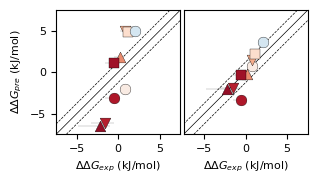

In [96]:
cmt = 1/2.54

all_res = []

solvents = solvent_mapping.values()
labels = ["A%i" % (i+1) for i in range(4)] + ["B%i" % (i+1) for i in range(4)] + ["C%i" % (i+1) for i in range(7)] + ["D%i" % (i+1) for i in range(7)]

fig, axd = plt.subplot_mosaic([["A3_GNNIS","A3_QMGNNIS"]],
                            figsize=(3.25,2.5),empty_sentinel="EMPTY",
                        )

gnn_orca_dif,cosmors_orca_dif,gnn_orca_ace_dif,smd_orca_dif,gnn_smd_orca_dif,exp_dif,color,names,exp_std = pinfs[0]["A3"]
plot_comp(axd["A3_QMGNNIS"],modify(exp_dif),modify(gnn_orca_ace_dif),exp_std,exclude_unknonws=True,s_size=60)
plot_comp(axd["A3_GNNIS"],modify(exp_dif),modify(cl_predictions),exp_std,exclude_unknonws=True,s_size=60)

lims = 7.5
# lims = 20

kbt = 2.479 / 2
for key in axd.keys():
    if key == "legend":
        continue
    ax = axd[key]
    ax.set_ylabel("$\Delta\Delta G_{pre}$ (kJ/mol)")
    ax.set_xlabel("$\Delta\Delta G_{exp}$ (kJ/mol)")
    ax.set_xlim(-lims,lims)
    ax.set_ylim(-lims,lims)
    ax.axline((0,0),(1,1),color='black',zorder=0,linestyle='-',linewidth=0.5)
    ax.axline((0,1*kbt),(1,1+kbt),color='black',zorder=0,linestyle='--',linewidth=0.5)
    ax.axline((0,-kbt),(1,1-kbt),color='black',zorder=0,linestyle='--',linewidth=0.5)
    # ax.axline((0,1*kbt*2),(1,1+kbt*2),color='black',zorder=0,linestyle='dotted',linewidth=0.5)
    # ax.axline((0,-kbt*2),(1,1-kbt*2),color='black',zorder=0,linestyle='dotted',linewidth=0.5)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    # set equal
    ax.set_aspect('equal', 'box')

# ax = axd["legend"]
# # add legend for colors
# legend_solvents = ['Chloroform','Ethylacetate','THF','DCM','acetone','Ethanol',"Methanol",'acetonitrile','DMSO']
# #ax.legend(handles=[Patch(facecolor=get_color_from_sd(SOLVENT_DICT[solvent]['dielectric']),label=SOLVENT_DICT[solvent]['nice_name']) for solvent in legend_solvents],loc="lower center",ncol=2,fontsize=8)
# ax.axis("off")

for key in ["A3_GNNIS","A3_QMGNNIS"]:
    axd[key].get_xaxis().set_visible(True)

for key in ["A3_GNNIS"]:
    axd[key].get_yaxis().set_visible(True)

fig.subplots_adjust(wspace=0.025, hspace=0.25)
fig.savefig(f"{figure_location}/Classical_vs_QM_A3.pdf",bbox_inches='tight')